## Progetto di Davide Donati, matricola 0001019487, corso di informatica.

In questo notebook descrivo le varie fasi del progetto di Apprendimento Automatico, che consiste nella creazione, nell'addestramento e nella valutazione di una rete neurale capace di ricostruire immagini sfocate.

In [1]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

2024-01-15 04:33:26.181200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 04:33:26.181263: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 04:33:26.182271: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 04:33:26.189641: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-15 04:33:27.060715: W tensorflow/compiler/tf2

Utilizziamo il dataset MNIST che contiene immagini di cifre scritte a mano.
Carichiamo il dataset e normalizziamo le immagini convertendole in valori in virgola mobile tra 0 e 1.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

Il generatore di immagini sfocate ci è stato fornito in precedenza.

In [3]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

### Modello simile U-Net
La U-Net è una rete neurale ottimizzata per l'elaborazione di immagini, particolarmente efficace in compiti di segmentazione e ricostruzione. La sua struttura caratterizzata da connessioni dirette tra i livelli di downscaling e upscaling migliora notevolmente la trasmissione di informazioni spaziali, risultando ideale per applicazioni come il deblurring.

Nello sviluppo di questo modello, ho intrapreso diverse sperimentazioni per aumentarne la potenza. La strategia iniziale consisteva nell'ampliamento della rete, sia attraverso l'aggiunta di ulteriori layer che incrementando la dimensione dei filtri. Tuttavia, questa approccio spesso portava a un fenomeno di overfitting. Per mitigare questo problema, ho introdotto dei residual blocks che hanno migliorato la propagazione del gradiente durante la fase di backpropagation.

In presenza di layer più profondi, si è reso necessario l'uso di funzioni di regolarizzazione dei kernel, come L1 e L2. Queste funzioni aiutano il modello a utilizzare pesi più significativi, penalizzando quelli troppo piccoli o grandi. Inoltre, l'impiego della tecnica di inizializzazione dei pesi "He Normal" ha contribuito a prevenire problemi di exploding o vanishing gradient.

Nonostante gli sforzi, ho incontrato difficoltà nel processo di data augmentation, principalmente a causa di problemi con il generatore di dati proposto. Per questo, ho optato per una struttura più semplice, mantenendo filtri di dimensioni considerevoli fin dal primo layer. Questa scelta si è rivelata efficace, bilanciando complessità e capacità di generalizzazione del modello.

#### Funzione di attivazione Mish
La funzione di attivazione Mish è preferita rispetto a ReLU o LeakyReLU poiché presenta proprietà migliori per modelli profondi, come il mio modello iniziale, è stata mantenuta perchè portava comunque migliori prestazioni. Essa combina i benefici di ReLU con una natura non monotona, permettendo una migliore regolazione del gradiente e riducendo il rischio di vanishing gradient. Inoltre, la sua natura non lineare e morbida aiuta a catturare le complessità all'interno dei dati in modo più efficace, contribuendo a migliorare la generalizzazione del modello.

#### Blocchi di convoluzione
I blocchi di convoluzione sono fondamentali in una rete neurale convoluzionale. Ogni blocco è composto da strati convoluzionali seguiti da una normalizzazione batch e una funzione di attivazione. Questa struttura aiuta a estrarre feature dai dati, mantenendo l'integrità delle informazioni spaziali. Matematicamente, questi blocchi applicano filtri sui dati di input, creando mappe di feature che evidenziano aspetti specifici delle immagini, come bordi, texture e pattern.

#### Encoder
L'encoder in una U-Net è utilizzato per comprimere l'input in una rappresentazione a bassa dimensione. Questo processo, detto anche downscaling, riduce progressivamente le dimensioni spaziali dell'input, permettendo alla rete di identificare e apprendere le caratteristiche più importanti. L'encoder è cruciale per ridurre il sovraccarico computazionale e per estrarre feature rilevanti a livelli diversi di astrazione.

#### Bridge
Il bridge in una U-Net agisce come un collegamento tra l'encoder e il decoder. È solitamente composto da uno o più strati convoluzionali che ulteriormente elaborano le feature estratte dall'encoder. Questa sezione è fondamentale per consolidare le informazioni apprese dall'encoder prima di passarle al decoder, contribuendo a una migliore ricostruzione dell'output.

#### Decoder
Il decoder nella U-Net si occupa di ricostruire l'output a partire dalla rappresentazione compressa fornita dall'encoder. Attraverso il processo di upscaling, il decoder incrementa progressivamente le dimensioni spaziali dei dati, usando le informazioni apprese durante l'encoding. Ciò consente di ricostruire un'immagine dettagliata a partire dalle feature astratte, ristabilendo le dimensioni originali dell'input.

#### Output
La scelta della funzione di attivazione sigmoide per l'output è dovuta alla sua capacità di normalizzare i valori dei pixel nell'intervallo [0, 1]. Questo è particolarmente utile in applicazioni come la segmentazione delle immagini, dove è necessario classificare ogni pixel. La sigmoide fornisce una probabilità chiara e limitata, facilitando la decisione se un pixel appartiene a una determinata classe o meno.

#### Ottimizzatore
La scelta di AdamW come ottimizzatore è stata guidata dai suoi vantaggi rispetto a varianti come Adam o Nadam, specialmente in contesti dove la regolarizzazione dei pesi è cruciale. AdamW migliora Adam separando il peso della decadenza dall'aggiornamento degli adattamenti, offrendo un controllo più preciso sulle penalità dei pesi. Questo si è tradotto in una convergenza più rapida e prestazioni migliori, anche in assenza di regolarizzazione L2.

#### Callbacks
Le callbacks utilizzate nel training sono strumenti essenziali per migliorare l'efficienza e l'efficacia dell'addestramento. EarlyStopping interrompe il training quando non si osservano miglioramenti, prevenendo l'overfitting. ReduceLROnPlateau riduce il learning rate quando il modello smette di migliorare, aiutando a trovare minimi locali più fini. Infine, ModelCheckpoint salva il miglior modello durante il training, assicurando che si mantenga la versione del modello con le migliori prestazioni.

In [5]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, Add, Layer, Cropping2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l1_l2
import tensorflow as tf

class Mish(Layer):
    def __init__(self):
        super(Mish, self).__init__()

    def call(self, inputs):
        return inputs * tf.tanh(tf.math.softplus(inputs))
    
def conv_block(input_tensor, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Mish()(x)

    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Mish()(x)

    return x

input_img = Input(shape=(28, 28, 1))

# Encoder
x2 = conv_block(input_img, 64)  
x2_pool = MaxPooling2D((2, 2), padding='same')(x2)
x2_pool = Dropout(0.1)(x2_pool)

x3 = conv_block(x2_pool, 128)  
x3_pool = MaxPooling2D((2, 2), padding='same')(x3)
x3_pool = Dropout(0.1)(x3_pool)

# Bridge
bridge = conv_block(x3_pool, 256)  

# Decoder
u2 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(bridge)
u2 = BatchNormalization()(u2)
u2 = Mish()(u2)
u2 = concatenate([u2, x3], axis=3)
u1 = conv_block(u2, 64)

u1 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(u2)
u1 = BatchNormalization()(u1)
u1 = Mish()(u1)
u1 = concatenate([u1, x2], axis=3)
u1 = conv_block(u1, 32)

# Output layer
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(u1)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=AdamW(0.001), loss='mean_squared_error', metrics=['accuracy'])

autoencoder.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)
checkpoint = ModelCheckpoint('modello_autoencoder_migliore.h5', verbose=1, save_best_only=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 28, 28, 64)           640       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_7 (Bat  (None, 28, 28, 64)           256       ['conv2d_6[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 mish_7 (Mish)               (None, 28, 28, 64)           0         ['batch_normalization_7[0]

 L'addestramento è diviso in steps, ognuno della durata di 4 epoche, per un totale di 12 epoche. In ogni step, vengono generati nuovi dati per l'addestramento e la validazione. Il modello viene addestrato a batch di 32 immagini, con dati di validazione utilizzati per monitorare la performance. 

 Questa configurazione è stata creata assieme ad un collega che mi ha offerto di affittargli la CPU per l'allenamento del modello, avendo io a disposizione unicamente un portatile(da questo derivano anche i Warnings nelle varie sezioni di codice).

In [6]:
# Parametri per il training
epochs = 12  # Numero di epoche per l'addestramento
epochs_per_step = 4  # Numero di epoche per ogni step
batch_size = 32  # Dimensione del batch

for i in range(epochs // epochs_per_step):
    # Generazione dei dati
    train_x, train_y = next(generator(x_train, epochs_per_step * 60000))
    val_data = next(generator(x_test, epochs_per_step * 10000))

    # Addestramento del modello autoencoder
    history = autoencoder.fit(
        x = train_x,
        y = train_y,
        steps_per_epoch=60000 // batch_size,
        batch_size=batch_size,
        epochs=epochs_per_step,
        validation_data=val_data,
        callbacks=[early_stopping, reduce_lr, checkpoint]
    )

Epoch 1/4


2024-01-15 04:34:03.784245: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-01-15 04:34:04.182237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-15 04:34:07.062750: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fd3fd9a6de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-15 04:34:07.062801: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2060 SUPER, Compute Capability 7.5
2024-01-15 04:34:07.068407: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705289647.200000   40660 device_compiler.h:186] Compiled cluster using

1875/1875 [==============================] - ETA: 0s - loss: 0.0120 - accuracy: 0.8112
Epoch 1: val_loss improved from inf to 0.00639, saving model to modello_autoencoder_migliore.h5


/home/bedru/anaconda3/envs/tfenv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1875/1875 [==============================] - 68s 31ms/step - loss: 0.0120 - accuracy: 0.8112 - val_loss: 0.0064 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 2/4
1875/1875 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.8143
Epoch 2: val_loss improved from 0.00639 to 0.00430, saving model to modello_autoencoder_migliore.h5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0052 - accuracy: 0.8143 - val_loss: 0.0043 - val_accuracy: 0.8135 - lr: 0.0010
Epoch 3/4
1875/1875 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.8143
Epoch 3: val_loss improved from 0.00430 to 0.00424, saving model to modello_autoencoder_migliore.h5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0042 - accuracy: 0.8143 - val_loss: 0.0042 - val_accuracy: 0.8134 - lr: 0.0010
Epoch 4/4
1874/1875 [============================>.] - ETA: 0s - loss: 0.0037 - accuracy: 0.8149
Epoch 4: val_loss improved from 0.00424 to 0.00346, saving model 

Il MSE è una misura della qualità della ricostruzione dell'immagine: valori più bassi indicano una migliore performance del modello, poiché significa che le immagini ricostruite sono più vicine a quelle originali.

Dalla valutazione effettuata, il MSE medio di validazione è 0.00228010830657196, che indica la media degli errori quadratici medi di tutte le prove effettuate. Una deviazione standard del MSE di 2.008833669153104e-05 suggerisce una bassa variabilità nei risultati del MSE tra le diverse prove, il che è indicativo di una performance consistente dell'autoencoder nel rimuovere il blur dalle immagini.

In conclusione, il modello sembra performare bene e con una consistenza affidabile nella rimozione del motion blur dalle immagini valutate.

In [17]:
from sklearn.metrics import mean_squared_error

def evaluate_model_multiple_times(autoencoder, generator, x_val, num_samples=10000, num_trials=10):
    mse_scores = []

    for _ in range(num_trials):
        blurred_images, original_images = next(generator(x_val, num_samples))
        y_pred = autoencoder.predict(blurred_images)

        # Calcolo MSE per il batch corrente
        batch_mse = mean_squared_error(original_images.reshape(-1), y_pred.reshape(-1))

        # Calcolo MSE medio per la valutazione corrente
        mse_scores.append(batch_mse)
    
    # Calcolo media e deviazione standard di tutti i punteggi MSE
    mean_mse = np.mean(mse_scores)
    std_mse = np.std(mse_scores)

    return mean_mse, std_mse, mse_scores

# Utilizzo della funzione di valutazione
mean_mse, std_mse, all_mse_scores = evaluate_model_multiple_times(autoencoder, generator, x_test, num_samples=10000, num_trials=10)
print(f"MSE medio di validazione: {mean_mse}")
print(f"Deviazione standard del MSE: {std_mse}")

313/313 [==============================] - 2s 6ms/step
MSE medio di validazione: 0.002280108630657196
Deviazione standard del MSE: 2.0088336896151304e-05


#### Grafico 1: Training and Validation Loss
Il primo grafico mostra una diminuzione della perdita di training con ogni epoca, indicando progressi nell'apprendimento del modello. La perdita di validazione rimane stabile, suggerendo che il modello mantiene una prestazione consistente sui dati di validazione.

#### Grafico 2: Training and Validation Accuracy (MSE)
Il secondo grafico illustra l'accuratezza di training e validazione, usando l'errore quadratico medio (MSE) come metrica. L'accuratezza di training migliora notevolmente, il che implica che il modello sta diventando più preciso nella previsione dei dati di training. L'accuratezza di validazione è coerente, indicando affidabilità nelle previsioni del modello su dati non visti.

#### Grafico 3: Distribuzione dei punteggi MSE
Il terzo grafico presenta una distribuzione uniforme dei punteggi MSE, indicando una consistenza nella performance del modello attraverso diverse iterazioni o set di dati. Questo suggerisce che il modello si comporta in modo prevedibile, un segno positivo per la valutazione di affidabilità e robustezza del modello stesso.

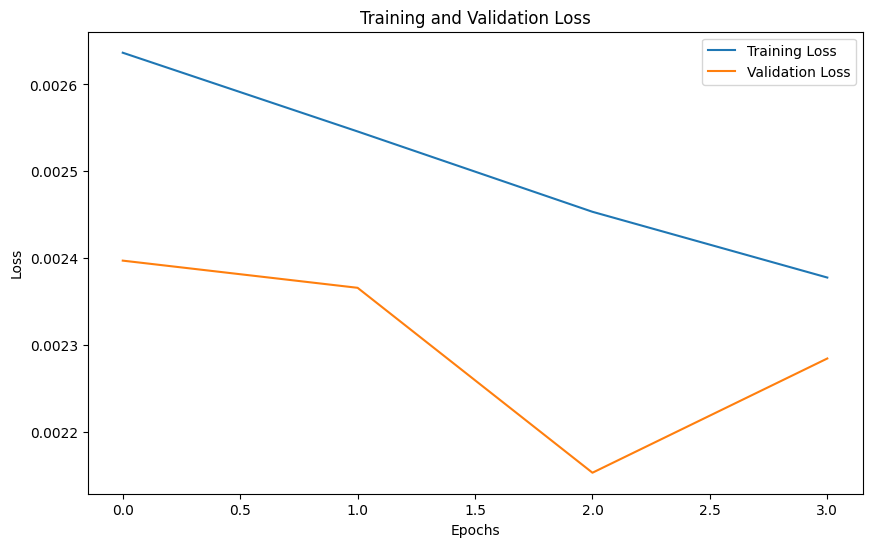

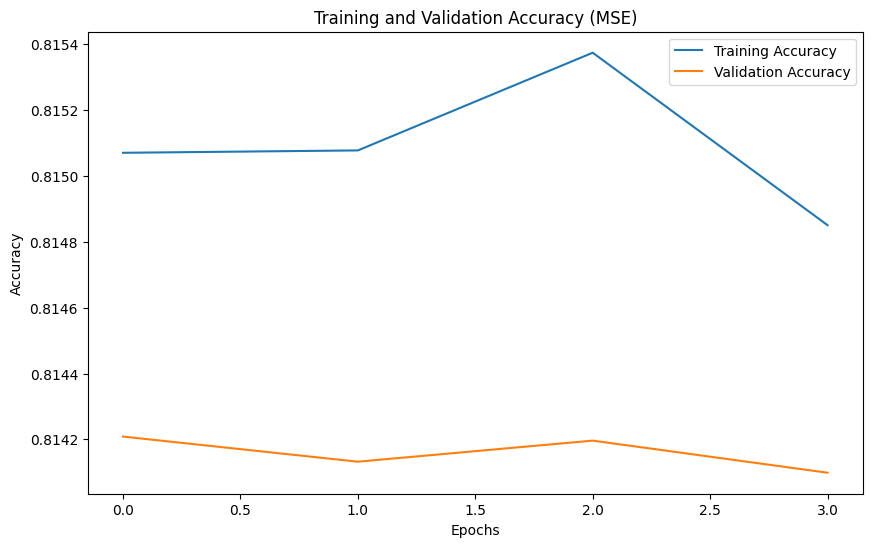

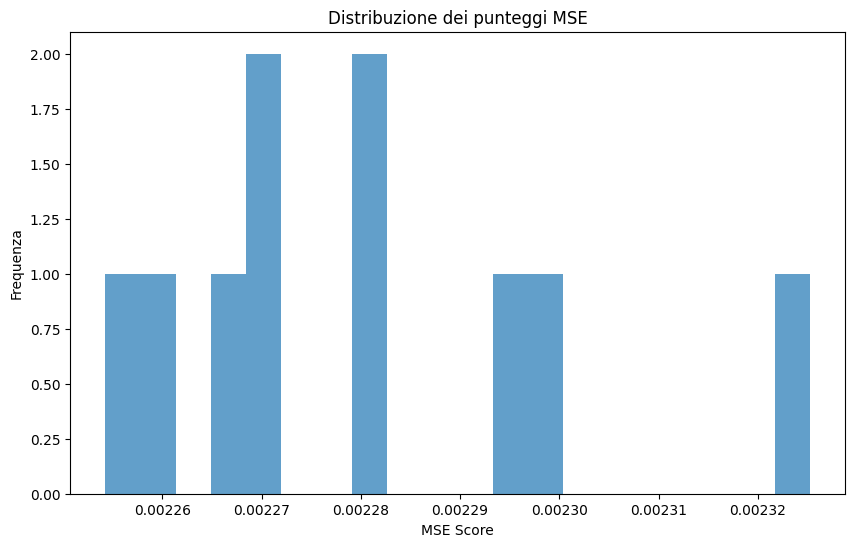

In [18]:
# Estrazione dei dati di training e validazione
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Grafico per Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Grafico per Training and Validation Accuracy (MSE)
plt.figure(figsize=(10, 6))
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Grafico per la Distribuzione dei punteggi MSE
plt.figure(figsize=(10, 6))
plt.hist(all_mse_scores, bins=20, alpha=0.7)
plt.title('Distribuzione dei punteggi MSE')
plt.xlabel('MSE Score')
plt.ylabel('Frequenza')
plt.show()

 La ricostruzione è stata tanto efficace che le immagini risultanti sono molto simili alle originali, dimostrando l'alta capacità dell'autoencoder di ripristinare fedelmente i dettagli originari persi a causa dello sfocamento. Questo risultato sottolinea il successo del progetto nel raggiungere l'obiettivo di ridurre significativamente l'effetto di motion blur dalle immagini.

1/1 [==============================] - 1s 914ms/step


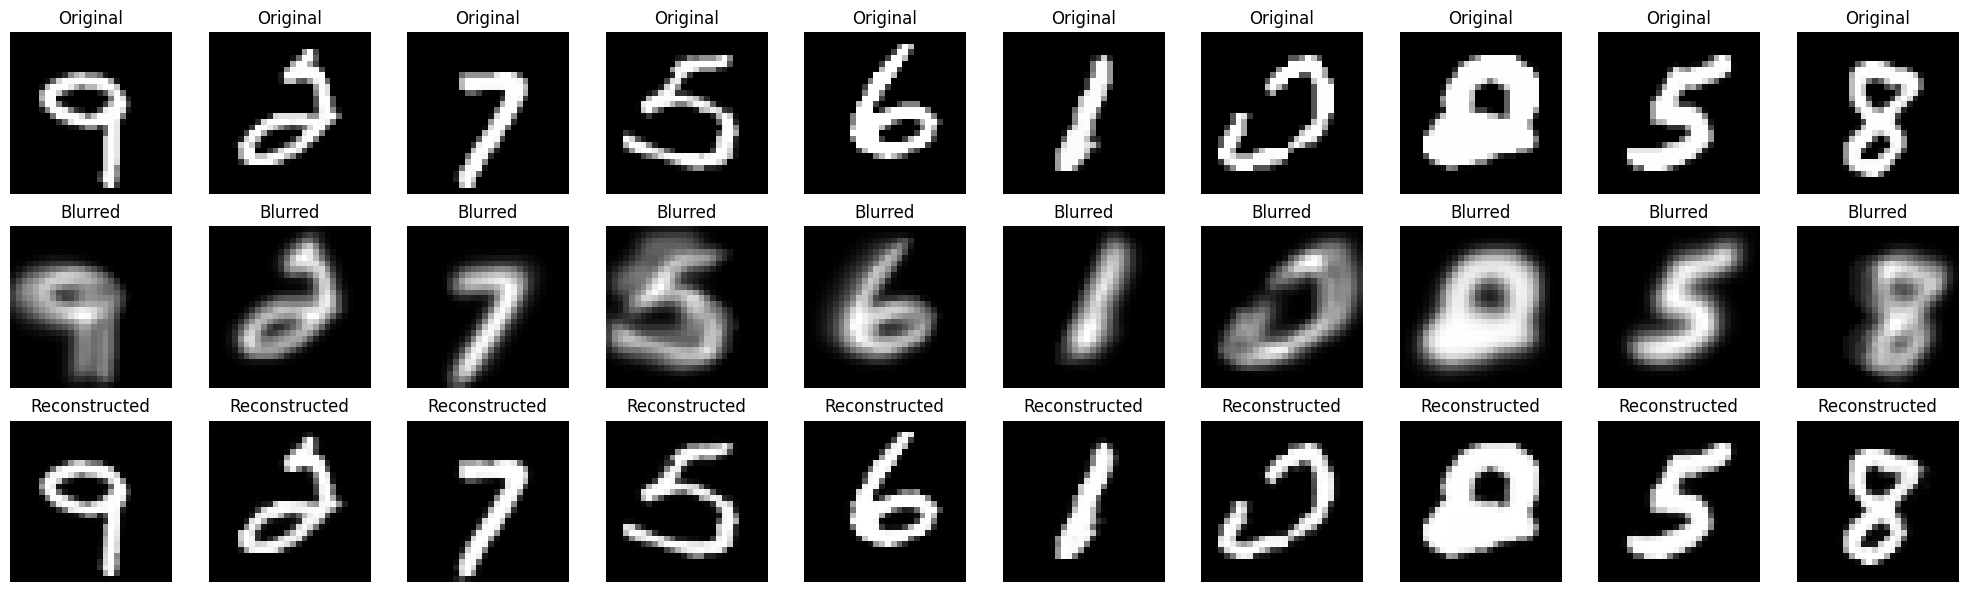

In [19]:
# Numero di immagini da generare e visualizzare
num_images = 10
blurred_images, original_images = [], []

# Genera le immagini dal generatore
for _ in range(num_images):
    blurred_batch, original_batch = next(generator(x_test, batch_size))
    blurred_images.append(blurred_batch[0])
    original_images.append(original_batch[0])

# Converti in array numpy
blurred_images = np.array(blurred_images)
original_images = np.array(original_images)

# Ricostruisci le immagini sfocate
reconstructed_images = autoencoder.predict(blurred_images)

# Visualizza le immagini
plt.figure(figsize=(20, 6))

for i in range(num_images):
    # Display original images
    ax = plt.subplot(3, num_images, i + 1)
    plt.imshow(original_images[i].reshape(28, 28), cmap='gray')
    ax.set_title("Original")
    ax.axis('off')

    # Display blurred images
    ax = plt.subplot(3, num_images, i + 1 + num_images)
    plt.imshow(blurred_images[i].reshape(28, 28), cmap='gray')
    ax.set_title("Blurred")
    ax.axis('off')

    # Display reconstructed images
    ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
    plt.imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    ax.set_title("Reconstructed")
    ax.axis('off')

plt.tight_layout()
plt.show()

